Le but de ce projet est de générer des informations sur l'investissement boursier en appliquant une analyse des sentiments de l'actualité financière. En utilisant cette technique de NLP, on peut comprendre l'émotion derrière les titres et prédire la position du marché par rapport aux actions d'une entreprise.

### Le dataset utilisé
On utilisera comme dataset les titres de l'actualité tirés de **Finviz.com**(On utilisera BeautifulSoup pour cela). On se focalisera sur deux entreprises **Facebook** et **Tesla** côtées en bourse, et qui alimentent constamment les actualités.
Pourquoi les titres seulement ? Parce que les titres, qui ont une longueur similaire, sont plus faciles à analyser et à regrouper que les articles complets, qui varient en longueur.
Finviz.com est une plateforme de recherche boursière qui offre des outils techniques et fondamentaux utiles pour les traders et les investisseurs. Finviz est l'abréviation de "financial visualization". Le site est surchargé de statistiques, de graphiques, de filtres, de heat maps, ainsi que de titres de nouvelles et de flux de médias sociaux.
<p><img src="https://daytradereview.com/wp-content/uploads/2017/09/NewsStreamer.jpg" alt="Facebook headlines from FINVIZ.com"></p>

Les titres des nouvelles d'actualité sont extraits de nombreux flux de nouvelles gratuits allant de PR Newswire, Briefing.com, MarketWatch, Bloomberg, CNN et NBC et des titres du Wall Street Journal. Les blogs sont également diffusés à partir de nombreuses sources gratuites tierces, notamment Seeking Alpha, Zero Hedge, Vantage Point Trading, Mish Talk, Calculated Risk, Ritholtz et Daily Reckoning.


In [20]:

from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}


for table_name in os.listdir('datasets'):
    
    table_path = f'datasets/{table_name}'
    
    table_file = open(table_path, 'r')
   
    html = BeautifulSoup(table_file)
   
    html_table = html.find(id="news-table")
    
    html_tables[table_name] = html_table

### Extraction des données
Dans cette partie, les titres d'actualités seront extraits de FinViz et traités pour préparer la Dataframe qui sera utilisée par la suite.

In [21]:

tsla = html_tables['tsla_22sep.html']

tsla_tr = tsla.findAll('tr')


for i, table_row in enumerate(tsla_tr):
    
    link_text = table_row.a.get_text()
    
    data_text = table_row.td.get_text()
   
    print(f'{i}:')
   
    print(link_text)
    print(data_text)
    
    if i == 3:
        break

0:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
1:
Broadcoms Stock Looks Like a Winner
09:30PM  
2:
SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
3:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


In [22]:

parsed_news = []

for file_name, news_table in html_tables.items():
    
    for x in news_table.findAll('tr'):
        
        text = x.get_text() 
        headline = x.a.get_text()
         
        date_scrape = x.td.text.split()
        
        if  len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

         
        ticker = file_name.split('_')[0]
       
        parsed_news.append([ticker, date, time, headline])

### Ajout de jargon financier
L'analyse des sentiments est très sensible au contexte.À titre d'exemple, dire "C'est tellement addictif!" signifie souvent quelque chose de positif si le contexte est un jeu vidéo, mais cela signifie très souvent quelque chose de négatif lorsque nous parlons de drogues. Les journalistes financiers ont eux aussi, comme la plupart des professionnels, leur propre jargon. Faisons maintenant penser NLTK comme un journaliste financier en ajoutant de nouveaux mots et valeurs de sentiment à notre lexique.

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
vader = SentimentIntensityAnalyzer()

vader.lexicon.update(new_words)

### Analyse des sentiments avec VADER
VADER Sentiment Analysis. <a href="https://github.com/cjhutto/vaderSentiment#introduction">VADER</a>  (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains. 

In [24]:

columns = ['ticker', 'date', 'time', 'headline']

scored_news = pd.DataFrame(parsed_news, columns=columns)

scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]

scores_df = pd.DataFrame(scores)

scored_news = pd.concat([scored_news, scores_df], axis=1)

scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

### Plot des scores
Maintenant que nous avons les scores, commençons à tracer les résultats.

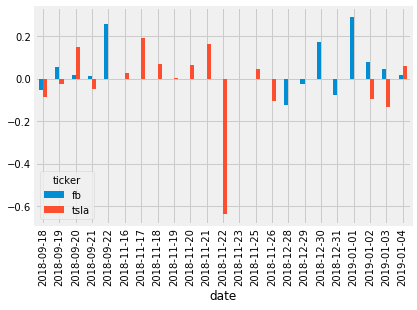

In [25]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline


mean_c = scored_news.groupby(['date', 'ticker']).mean()

mean_c = mean_c.unstack(level=1)

mean_c = mean_c.xs('compound', axis=1)

mean_c.plot.bar()
plt.savefig('scores.png')

### Elimination des doublons
Comme on peut le voir à la date du 22 novembre pour Tesla, le score paraît comme un point abérant. Après inspection, on se rend compte de quelques problèmes:
+ Il n'y a que 5 titres pour cette journée.
+ Deux gros titres sont textuellement identiques à un autre mais provenant d'un autre média.

Alors que certains titres sont la même nouvelle provenant de différentes sources, le fait qu'ils soient écrits différemment pourrait fournir des perspectives différentes sur la même histoire. De plus, lorsqu'une nouvelle est plus importante, elle a tendance à obtenir plus de titres de plusieurs sources. Ce dont nous voulons nous débarrasser, ce sont les titres copiés textuellement, car ils proviennent très probablement du même journaliste et sont simplement "dupliqués".

In [26]:

num_news_before = scored_news['headline'].count()

scored_news_clean = scored_news.drop_duplicates(subset=['ticker', 'headline'])

num_news_after = scored_news_clean['headline'].count()

f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

### Plot des scores de Facebook

In [27]:

single_day = scored_news_clean.set_index(['ticker', 'date'])

single_day = single_day.loc['fb']

single_day = single_day.loc['2019-01-03']

single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time 

single_day = single_day.set_index('time')

single_day = single_day.sort_index(ascending=True)

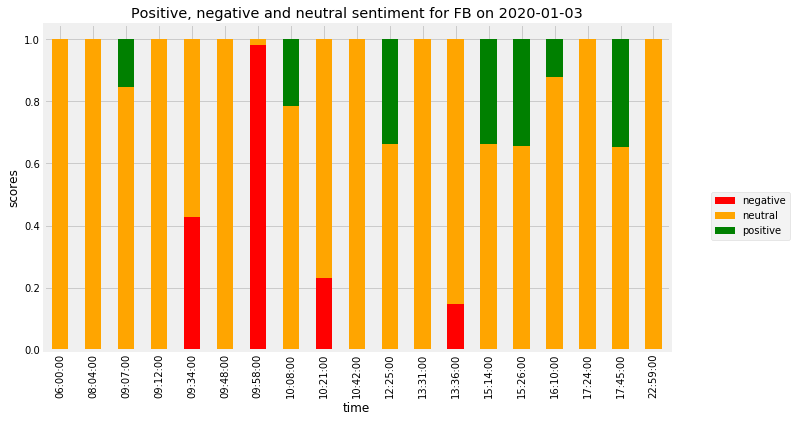

In [28]:
TITLE = "Positive, negative and neutral sentiment for FB on 2020-01-03"
COLORS = ["red", "orange", "green"]

plot_day = single_day.drop(['headline', 'compound'], axis=1)

plot_day.columns = ['negative', 'neutral', 'positive']


plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = TITLE, 
                  color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");
plt.savefig('FB_scores.png')

### comparaison des données

In [29]:
fb = pd.read_csv("FB.csv")
tsla = pd.read_csv("TSLA.csv")
fb.Date = pd.to_datetime(fb.Date).dt.date
tsla.Date = pd.to_datetime(tsla.Date).dt.date

fb = fb.set_index('Date')
fb.index.name = 'date'
fb = fb.drop(fb.columns[[0, 1,2,4,5]], axis=1)
fb=(fb-fb.mean())/fb.std()

tsla = tsla.set_index('Date')
tsla.index.name = 'date'
tsla = tsla.drop(tsla.columns[[0, 1,2,4,5]], axis=1)
tsla=(tsla-tsla.mean())/tsla.std()

In [30]:
joined_fb = fb.join(mean_c['fb'],how='outer')
joined_tsla = tsla.join(mean_c['tsla'],how='outer')

joined_fb.index = pd.to_datetime(joined_fb.index)
joined_tsla.index = pd.to_datetime(joined_tsla.index)

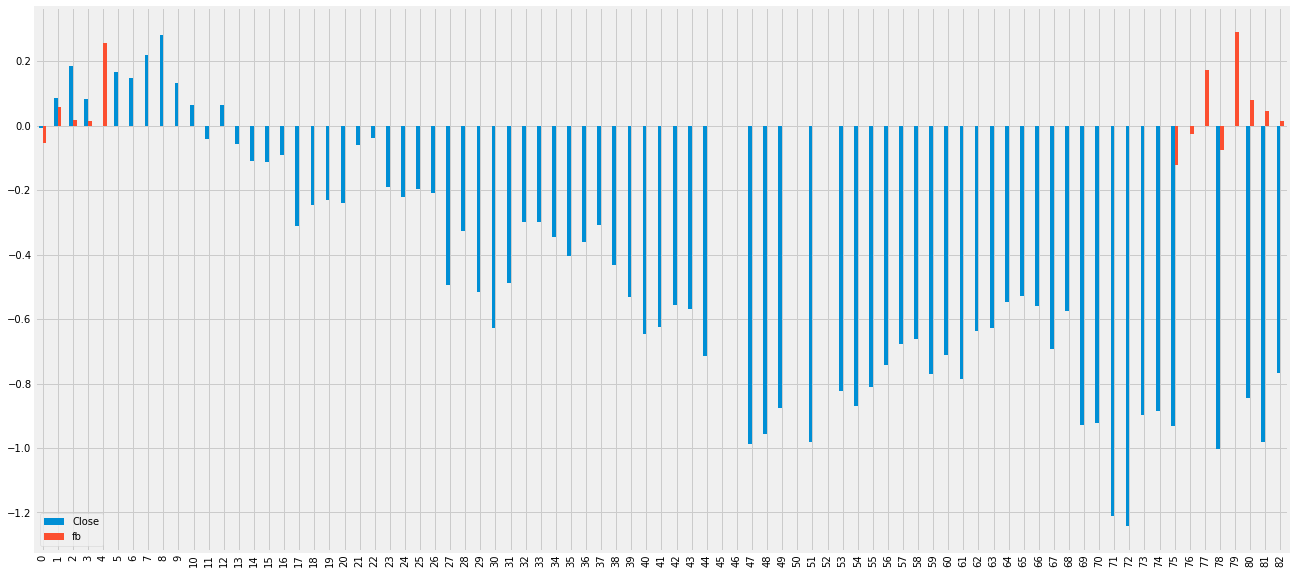

In [31]:
joined_fb.loc['2018-09-18':'2019-01-04'].plot(kind = 'bar',figsize = (20,10), use_index = False)
plt.savefig('fb_stock.png')

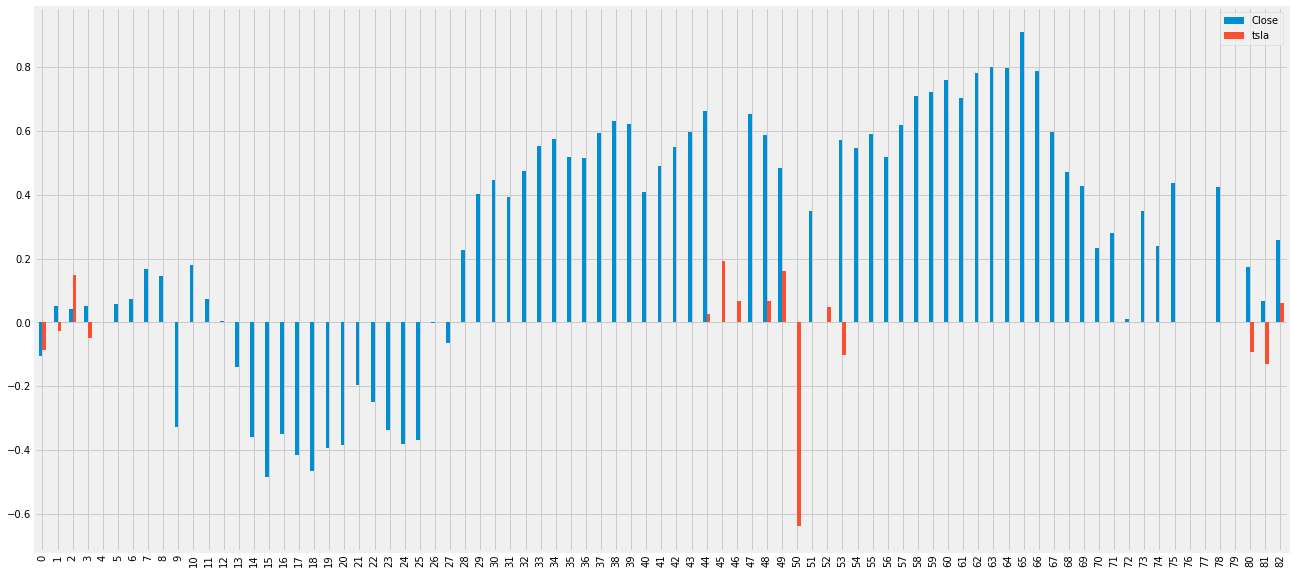

In [32]:
joined_tsla.loc['2018-09-18':'2019-01-04'].plot(kind = 'bar',figsize = (20,10), use_index = False)
plt.savefig('tsla_stock.png')